In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, GaussianNoise, BatchNormalization, UpSampling2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [3]:
'mnist' in tfds.list_builders()

True

# Loading data and preprocessing

In [4]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


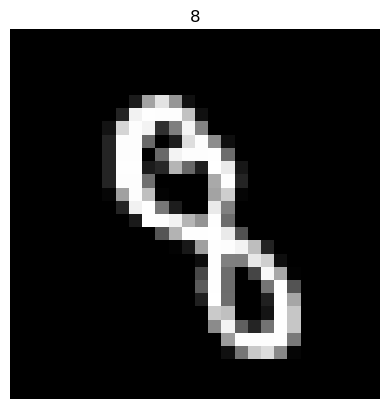

In [5]:
import numpy as np
# Datapreprocessing
x_train = x_train.reshape((60_000, 28, 28, 1))
x_test = x_test.reshape((10_000, 28, 28, 1))

# Normalizing the values
x_train = x_train.astype(np.float64)/255.0
x_test = x_test.astype(np.float64)/255.0

idx = np.random.randint(0,60_000)
plt.imshow(x_train[idx, :, :, :], cmap='gray')
plt.title(y_train[idx])
plt.axis('off')
plt.show()


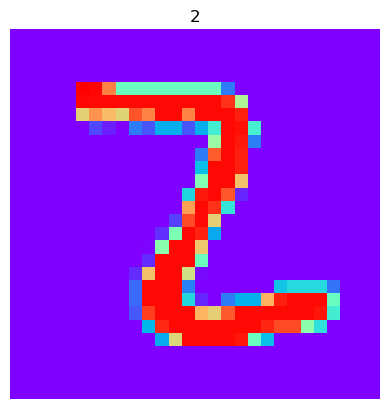

In [6]:
idx = np.random.randint(0,60_000)
plt.imshow(x_train[idx, :, :, :], cmap='rainbow')
plt.title(y_train[idx])
plt.axis('off')
plt.show()

# Change dataset into something easy to process using tensorflow

In [7]:
batch_size = 32

# Prepare the training dataset
# Need only images, not labels
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Make a Generator and Discriminator model

In [8]:
def make_generator():
    input_noise = Input(128, name='Noise-input')
    x = Dense(128*2, activation='relu')(input_noise)
    x = BatchNormalization()(x)
    x = Dense(784, activation='relu')(x)
    output_img = Reshape((28,28,1))(x)
    model = Model(inputs = [input_noise], outputs = [output_img], name="Generator-model")
    return model

In [9]:
generator = make_generator()
generator.summary()

Model: "Generator-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Noise-input (InputLayer)    [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 235,536
Trainable params: 235,024
Non-trainable params: 512
___________________________________________

In [10]:
def make_discriminator():
    input_image = Input((28, 28, 1), name='Image-input')
    x = GaussianNoise(0.5)(input_image)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation="relu")(x)
    x = Flatten()(x)
    x = Dense(200, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="softmax")(x) # classify real or fake
    model = Model(inputs=[input_image], outputs=[output], name="Discriminator-model")
    return model

In [11]:
discriminator = make_discriminator()
discriminator.summary()

Model: "Discriminator-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image-input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 28, 28, 1)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 3872)      

# Testing the generator

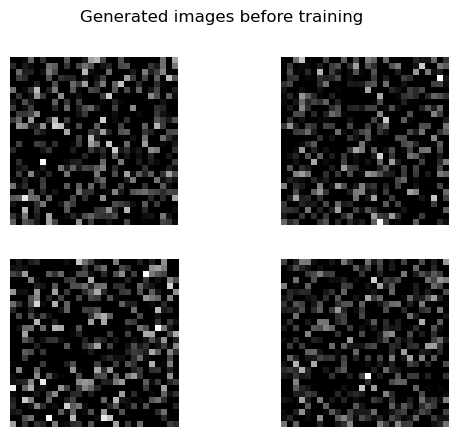

In [12]:
noise_in = tf.random.normal((4, 128), seed=32)

gen_ = generator(noise_in)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(gen_[i], cmap='gray')
    plt.axis('off')
#     plt.title(i+1)
plt.suptitle("Generated images before training")
plt.show()

# Defining the GAN class

In [13]:
class MyGan(Model):
    def __init__(self, generator_nn, discriminator_nn):
        super().__init__()
        self.generator = generator_nn
        self.discriminator = discriminator_nn
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile the parent class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 
        
    def train_step(self, batch):
#         print("I'm here now!")
        # make data to train the discriminator
        real_data = batch
        noise_ = tf.random.normal((128,128,1)) # noise to generate image
        gen_data = self.generator(noise_, training=False)
#         all_data = tf.concat([real_data, gen_data], axis=0) 
#         y = tf.concat([tf.zeros(real_data.shape[0]), tf.ones(gen_data.shape[0])], axis=0) # make true labels
        
        # Train Discriminator; Track gradients
        with tf.GradientTape() as d_tape:
            y_hat_0 = self.discriminator(real_data, training=True) # Make prediction
            y_hat_1 = self.discriminator(gen_data, training=True) # Make prediction
            y_hat = tf.concat([y_hat_0, y_hat_1], axis=0) # All predictions
            y = tf.concat([tf.zeros_like(y_hat_0), tf.ones_like(y_hat_1)], axis=0) # True labels
            all_d_loss = self.d_loss(y, y_hat) # Compute loss
        d_gradients = d_tape.gradient(all_d_loss, self.discriminator.trainable_variables) # Compute gradients
        self.d_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables)) #Apply gradients
            
        # Train Generator; Track gradients
        with tf.GradientTape() as g_tape:
#             noise_ = tf.random.normal(batch[0].shape)
            gen_images = self.generator(noise_, training=True) # generate images
            pred = self.discriminator(gen_images, training=False) # pass through discriminator
            all_g_loss = self.g_loss(tf.zeros_like(pred), pred) # discriminator needs to be fooled
        g_gradients = g_tape.gradient(all_g_loss, self.generator.trainable_variables) # Compute gradients
        self.g_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables)) # Apply gradients
        
        return {"d_loss": all_d_loss, "g_loss":all_g_loss}

In [14]:
generator_optimizer = Adam(learning_rate=0.01)
discriminator_optimizer = Adam(learning_rate=0.01)
generator_loss = BinaryCrossentropy() # can also use BinaryCrossentropy
discriminator_loss = BinaryCrossentropy() # can also use BinaryCrossentropy

In [15]:
mnist_gan = MyGan(generator, discriminator)

In [16]:
mnist_gan.generator.summary()
print()
print()
mnist_gan.discriminator.summary()


Model: "Generator-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Noise-input (InputLayer)    [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 235,536
Trainable params: 235,024
Non-trainable params: 512
___________________________________________

In [17]:
mnist_gan.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [18]:
hist = mnist_gan.fit(train_dataset, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 43s 18ms/step - d_loss: 3.0498 - g_loss: 0.0029
Epoch 2/20
1875/1875 [==============================] - 33s 18ms/step - d_loss: 3.0498 - g_loss: 9.5918e-07
Epoch 3/20
1875/1875 [==============================] - 32s 17ms/step - d_loss: 3.0498 - g_loss: 2.3292e-07
Epoch 4/20
1875/1875 [==============================] - 36s 19ms/step - d_loss: 3.0498 - g_loss: 7.5301e-08
Epoch 5/20
1875/1875 [==============================] - 37s 19ms/step - d_loss: 3.0498 - g_loss: 2.7390e-08
Epoch 6/20
1875/1875 [==============================] - 36s 19ms/step - d_loss: 3.0498 - g_loss: 1.1092e-08
Epoch 7/20
1875/1875 [==============================] - 37s 20ms/step - d_loss: 3.0498 - g_loss: 5.0318e-09
Epoch 8/20
1875/1875 [==============================] - 37s 20ms/step - d_loss: 3.0498 - g_loss: 2.5525e-09
Epoch 9/20
1875/1875 [==============================] - 34s 18ms/step - d_loss: 3.0498 - g_loss: 1.4675e-09
Epoch 10/20
1875/1875 [=========

# Testing generator for improvement

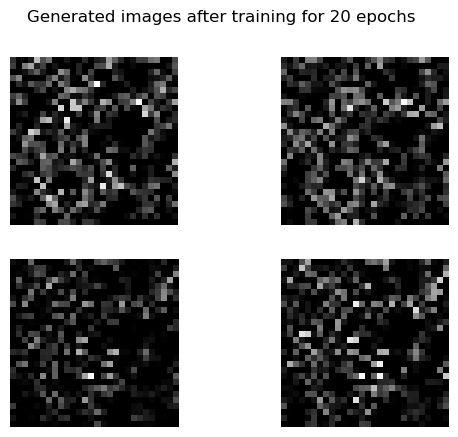

In [23]:
noise_in = tf.random.normal((4, 128), seed=32)

gen_ = generator(noise_in)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(gen_[i], cmap='gray')
    plt.axis('off')
#     plt.title(i+1)
plt.suptitle("Generated images after training for 20 epochs")
plt.show()

In [ ]:
discriminator